# Autoencoding Financial Transactions

### All financial transaction information is not of equal value so let's compress financial transaction processing to focus on more meaningful information

### An Autoencoder is an Artificial Neural Network capable of learning dense representations of input data and enhancing our observations to uncover underlying structures

[0.13501015 0.12577773 0.12031401]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


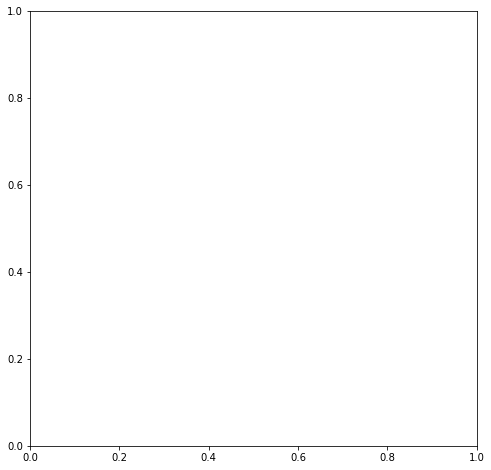

[0.20577961 0.14728955 0.09800458]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


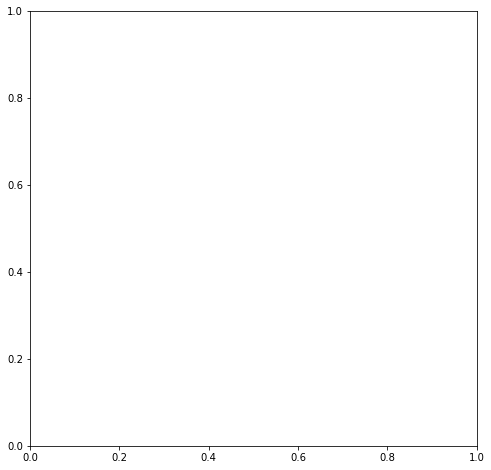

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, decomposition, preprocessing


def show_pca_df(df):
    x = df[df.columns[1:30]].to_numpy()
    y = df[df.columns[30]].to_numpy()

    x = preprocessing.MinMaxScaler().fit_transform(x)
    pca = decomposition.PCA(n_components=3)
    pca_result = pca.fit_transform(x)
    print(pca.explained_variance_ratio_)

    pca_df = pd.DataFrame(data=pca_result, columns=['pc_1', 'pc_2', 'pc_3'])
    pca_df = pd.concat([pca_df, pd.DataFrame({'label': y})], axis=1)

    ax = Axes3D(plt.figure(figsize=(8, 8)))
    ax.scatter(xs=pca_df['pc_1'], ys=pca_df['pc_2'], zs=pca_df['pc_3'], c=pca_df['label'], s=25)
    ax.set_xlabel("pc_1")
    ax.set_ylabel("pc_2")
    ax.set_zlabel("pc_3")
    ax = plt.subplot(label='testlabel')
    plt.show()

df = pd.read_csv('creditcard.csv')

show_pca_df(df)

df_anomaly = df[df[df.columns[30]] > 0]

df_normal = df[df[df.columns[30]] == 0].sample(n=df_anomaly.size, random_state=1, axis='index')

df = pd.concat([ df_anomaly, df_normal])


show_pca_df(df)

In [1]:
import sys

print(sys.version)

3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, decomposition, preprocessing, model_selection
from keras import models, layers, activations, losses, optimizers, metrics
from keras.callbacks import EarlyStopping
import seaborn as sns


df = pd.read_csv('creditcard.csv')

x = df[df.columns[1:30]].to_numpy()
y = df[df.columns[30]].to_numpy()

# prepare data
df = pd.concat([pd.DataFrame(x), pd.DataFrame({'anomaly': y})], axis=1)
normal_events = df[df['anomaly'] == 0]
abnormal_events = df[df['anomaly'] == 1]

normal_events = normal_events.loc[:, normal_events.columns != 'anomaly']
abnormal_events = abnormal_events.loc[:, abnormal_events.columns != 'anomaly']

# scaling
scaler = preprocessing.MinMaxScaler()
scaler.fit(df.drop('anomaly', 1))

scaled_data = scaler.transform(normal_events)

# 80% percent of dataset is designated to training
train_data, test_data = model_selection.train_test_split(scaled_data, test_size=0.2)

n_features = x.shape[1]
print(n_features)
# model
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=20, activation=activations.relu, input_shape=[n_features]))
encoder.add(layers.Dropout(0.1))
encoder.add(layer=layers.Dense(units=10, activation=activations.relu))
encoder.add(layer=layers.Dense(units=5, activation=activations.relu))

decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=10, activation=activations.relu, input_shape=[5]))
decoder.add(layer=layers.Dense(units=20, activation=activations.relu))
decoder.add(layers.Dropout(0.1))
decoder.add(layer=layers.Dense(units=n_features, activation=activations.sigmoid))

autoencoder = models.Sequential([encoder, decoder])

autoencoder.compile(
    loss=losses.MSE,
    optimizer=optimizers.Adam(),
    metrics=[metrics.mean_squared_error])

# train model
es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=20, restore_best_weights=True)
history = autoencoder.fit(x=train_data, y=train_data, epochs=100, verbose=1, validation_data=[test_data, test_data], callbacks=[es])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

autoencoder.save('autoencoder.h5')

train_predicted_x = autoencoder.predict(x=train_data)
train_events_mse = losses.mean_squared_error(train_data, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)
print('cut_off:', cut_off)
# cut_off: 0.0013734778214711686

#####
plot_samples = 100
# normal event
real_x = test_data[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=real_x)
normal_events_mse = losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({
    'mse': normal_events_mse,
    'n': np.arange(0, plot_samples),
    'anomaly': np.zeros(plot_samples)})



# abnormal event
abnormal_x = scaler.transform(abnormal_events)[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=abnormal_x)
abnormal_events_mse = losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
    'mse': abnormal_events_mse,
    'n': np.arange(0, plot_samples),
    'anomaly': np.ones(plot_samples)})

mse_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

line = lines.Line2D(
    xdata=np.arange(0, plot_samples),
    ydata=np.full(plot_samples, cut_off),
    color='#CC2B5E',
    linewidth=1.5,
    linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off))
plt.show()

AttributeError: module 'pyparsing' has no attribute 'downcaseTokens'